## Gradient Boosting

- [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is another ensemble technique for classification and regression. It can be viewed as a "series circuit" of base learners.


- The idea of gradient boosting originates from [Leo Breiman](https://en.wikipedia.org/wiki/Leo_Breiman) and [Jerome Friedman](https://en.wikipedia.org/wiki/Jerome_H._Friedman) (1999).


- The diversity of the base learners is achieved by training them on different targets.


- The base learners are regressors, both for classification and regression.


- Usually, the base learners are decision tree regressors, but in theory they could be any regression algorithm.


- Gradient Boosted Decision Trees (or Gradient Boosting Machine) is a "swiss army knife" method in machine learning. It is invariant to the scale of the feature values and performs well on a wide variety of problems.

### Pseudo Code of Training (w/o Learning Rate)
<img src="../_img/gradient_boosting_algorithm.png" width="600px">

### Learning Rate

- instead of step size $\gamma_m$, we use $\eta \cdot \gamma_m$, where $\eta \in (0, 1]$
- $\eta<1$ implements the "slow cooking" idea, and in practice leads to better ensembles than $\eta=1$

<img src="../_img/slow_cooking.jpg" width="250px">

### Special Case: Gradient Boosting for Regression

- the loss function is the squared loss: $L(y, F(x)) = \frac{1}{2} \left(y - F(x)\right)^2$
- the initial model is the average target: $F_0(x) = \frac{1}{n} \sum_{i=1}^n y_i$
- pseudo-residuals: $r_{im} = y_i - F_{m-1}(x_i)$
- optimal multiplier: $\gamma_m = \left[\sum_{i=1}^n h_m(x_i)r_{im}\right] / \left[\sum_{i=1}^n \left(h_m(x_i)\right)^2\right]$

**Exercise 1**: Implement a tree based gradient boosting regressor and evaluate it on the Boston Housing data set using 3-fold cross-validation! Use a maximal tree depth of 3!

In [1]:
# Load the Boston Housing data set.
import pandas as pd
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
         'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV']
df = pd.read_csv('../_data/housing_data.txt', delim_whitespace=True, names=names)
df = df.sample(len(df), random_state=42) # data shuffling
X = df.values[:, :-1] # input matrix
y = df['MEDV'].values # target vector

In [2]:
'''from sklearn.tree import DecisionTreeRegressor

eta = .1 # learning rate
n_estimators = 100 # number of trees

yhat0 = y.mean()
r = y - yhat0

trees = []
for k in range(n_estimators):

    tree = DecisionTreeRegressor(max_depth=3, random_state=42)
    tree.fit(X, r)
    h = tree.predict(X)
    w = eta * (h @ r) / (h @ h)
    r -= w * h
    trees.append((w, tree))
    
trees
'''

'from sklearn.tree import DecisionTreeRegressor\n\neta = .1 # learning rate\nn_estimators = 100 # number of trees\n\nyhat0 = y.mean()\nr = y - yhat0\n\ntrees = []\nfor k in range(n_estimators):\n\n    tree = DecisionTreeRegressor(max_depth=3, random_state=42)\n    tree.fit(X, r)\n    h = tree.predict(X)\n    w = eta * (h @ r) / (h @ h)\n    r -= w * h\n    trees.append((w, tree))\n    \ntrees\n'

In [3]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
class MyGradientBoostingRegressor:
    def __init__(self, eta=0.1, n_estimators=100, max_depth=3):
        self.eta=eta
        self.n_estimators=n_estimators
        self.max_depth=max_depth

    def fit(self, X, y):
        self.yhat0 = y.mean()
        r = y - self.yhat0
        
        self.trees = []
        for k in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, r)
            h = tree.predict(X)
            w = self.eta * (h @ r) / (h @ h)
            r -= w * h
            self.trees.append((w, tree))
        return self
    
    def predict(self, X):
        yhat = np.ones(len(X)) * self.yhat0
        for w, tree in self.trees:
            yhat += w * tree.predict(X)
        return yhat
    

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def evaluate(re, X, y):
    cv = KFold(3, shuffle=True, random_state=42)
    scores = []
    for tr, te in cv.split(X):
        re.fit(X[tr], y[tr])
        yhat = re.predict(X)
        rmse = mean_squared_error(y[te], yhat[te])**0.5
        scores.append(rmse)
    return np.mean(scores)

In [5]:
evaluate(MyGradientBoostingRegressor(), X, y)

3.375684135715931

**Exercise 2**: Repeat the previous experiment using scikit-learn!

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
evaluate(GradientBoostingRegressor(random_state=42), X, y)

3.36820868174328

**Exercise 3**: Which tree depth gives the most accurate ensemble?

In [ ]:
res = []
for max_depth in range(1, 13):
    print(max_depth, end=' ')
    rmse = evaluate(GradientBoostingRegressor(random_state=42, max_depth=max_depth), X, y)
    res.append({
        'max_depth': max_depth,
        'rmse': rmse
    })

1 

In [ ]:
pd.DataFrame(res).set_index('max_depth').plot()

**Exercise 3/B**: How the training and test RMSE changes with the number of trees? (Use a simple train-test split for this experiment!)

In [ ]:
from sklearn.model_selection import train_test_split

tr, te = train_test_split(np.arange(len(X)), train_size=0.7, random_state=42)
res = []
for max_depth in range(1, 13):
    print(max_depth, end=' ')
    re = GradientBoostingRegressor(random_state=42, max_depth=max_depth)
    re.fit(X[tr], y[tr])
    yhat = re.predict(X)
    res.append({
        'max_depth' : max_depth,
        'rmse_tr' : mean_squared_error(y[tr], yhat[tr])**.5,
        'rmse_te' : mean_squared_error(y[te], yhat[te])**.5
    })

In [ ]:
pd.DataFrame(res).set_index('max_depth').plot(grid=True)

**Exercise 4**: Apply a random forest and a gradient boosting classifier on the Wisconsin Breast Cancer data set! Use stratified 10-fold cross-validation! The evaluation metric should be the ratio of correct classifications. For both ensemble methods, determine the maximal tree depth that gives the highest accuracy!

In [1]:
# Load the Wisconsin Breast Cancer data set.
import pandas as pd
names = [
    'Sample_code_number', 'Clump_Thickness', 'Uniformity_of_Cell_Size',
    'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
    'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class'
]
df = pd.read_csv('../_data/wisconsin_data.txt', sep=',', names=names, na_values='?')
df = df.sample(len(df), random_state=42) # data shuffling
df['Bare_Nuclei'].fillna(0, inplace=True)
X = df[df.columns[1: -1]].values
y = (df['Class'].values / 2 - 1).astype('int')

In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

cl = RandomForestClassifier()

def evaluate(cl, X, y):
    scores = []
    cv = StratifiedKFold(10, shuffle=True, random_state=42)
    for tr, te in cv.split(X, y):
        cl.fit(X[tr], y[tr])
        yhat = cl.predict(X)
        scores.append(accuracy_score(y[te], yhat[te]))
    return np.mean(scores)

In [10]:
%%time
evaluate(RandomForestClassifier(random_state=42), X, y)

CPU times: user 1.78 s, sys: 11.8 ms, total: 1.79 s
Wall time: 1.8 s


0.9698964803312631

In [11]:
%%time
evaluate(GradientBoostingClassifier(random_state=42), X, y)

CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 1.26 s


0.9527536231884058

In [16]:
from sklearn.dummy import DummyClassifier
evaluate(DummyClassifier(random_state=42), X, y)

0.6552173913043479

In [19]:
#%%time
from sklearn.linear_model import LogisticRegression
evaluate(LogisticRegression(random_state=42), X, y)

0.9656314699792962

In [14]:
res = []
for max_depth in range(1, 12):
    print(max_depth, end=' ')
    res.append({
        'max_depth' : max_depth,
        'rf_acc' : evaluate(RandomForestClassifier(random_state=42, max_depth=max_depth), X, y),
        'gb_acc' : evaluate(GradientBoostingClassifier(random_state=42, max_depth=max_depth), X, y)
    })

1 2 3 4 5 6 7 8 9 10 11 

<AxesSubplot: xlabel='max_depth'>

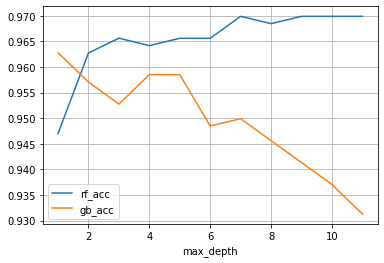

In [15]:
pd.DataFrame(res).set_index('max_depth').plot(grid=True)

### Gradient Boosting on Steroids

- [XGBoost](https://en.wikipedia.org/wiki/XGBoost) and [LightGBM](https://en.wikipedia.org/wiki/LightGBM) are a highly efficient and flexible implementations of gradient boosting.
- XGBoost started as a research project by Tianqi Chen (in 2014).
- LightGBM was introduced by Microsoft Research (in 2016).

**Exercise 5**: Compare XGBoost, LightGBM and scikit-learn's GradientBoostingClassifier on the Wisconsin Breast Cancer problem, in terms of speed and accuracy!

In [22]:
import xgboost
xgboost.__version__

'1.7.3'

In [31]:
from xgboost import XGBClassifier
%timeit evaluate(XGBClassifier(max_depth=3, random_state=42), X, y)

396 ms ± 5.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
evaluate(XGBClassifier(max_depth=3, random_state=42), X, y)

0.9585093167701864

In [32]:
from lightgbm import LGBMClassifier
%timeit evaluate(LGBMClassifier(max_depth=3, random_state=42), X, y)

208 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
evaluate(LGBMClassifier(max_depth=3, random_state=42), X, y)

0.9585093167701866

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
%timeit evaluate(GradientBoostingClassifier(max_depth=3, random_state=42), X, y)

1.16 s ± 4.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
evaluate(GradientBoostingClassifier(max_depth=3, random_state=42), X, y)

0.9527536231884058

In [42]:
from sklearn.ensemble import HistGradientBoostingClassifier

%timeit evaluate(HistGradientBoostingClassifier(max_depth=3, random_state=42), X, y)

1.79 s ± 805 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
evaluate(HistGradientBoostingClassifier(max_depth=3, random_state=42), X, y)

0.9584886128364388